In [ ]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from skimage.measure import block_reduce
from skimage.transform import resize

# Amazon bounds
lat_min, lat_max = -10, 5
lon_min, lon_max = -75, -50

sif_amazon = []
time_list = []

data_dir = data_dir = "/Users/carmenoliver/Desktop/SIF_anomalies/SIF_DATA_TROPOMI/"

# Get all available files
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
print("Files found:", files)
for file in files:
    match = re.search(r"month-(\d{6})", file)
    if match:
        date_str = match.group(1)  # Extract YYYYMM
        year = int(date_str[:4])  
        month = int(date_str[4:6])  

        file_path = os.path.join(data_dir, file)
        
        try:
            ds = xr.open_dataset(file_path)
        except Exception as e:
            print(f"Error opening {file_path}: {e}")
            continue
        ds_amazon = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
        
        sif_amazon.append(ds_amazon["solar_induced_fluorescence"].values)  # Shape: [time, lat, lon]
        time_list.append(f"{year}-{month:02d}")
        # Ensure data was loaded
if not sif_amazon or not time_list:
    raise ValueError("No valid data found. Check the input files and filtering logic.")
# Convert to numpy array
sif_amazon = np.stack(sif_amazon, axis=0).squeeze()  # Shape: [N_months, lat, lon]

# Group into years
years = sorted(set(int(t.split("-")[0]) for t in time_list))

num_years = len(years)

# Initialize an empty array with NaNs
sif_monthly = np.full((num_years, 12, *sif_amazon.shape[1:]), np.nan)
# Fill in available months
for i, month_data in enumerate(sif_amazon):
    year_idx = i // 12  # Get year index
    month_idx = i % 12  # Get month index
    sif_monthly[year_idx, month_idx] = month_data  # Assign data

print("Fixed sif_monthly shape:", sif_monthly.shape)
# solar_induced_fluorescence_uncertainty         (time, latitude, longitude) float32 537MB .
#solar_induced_fluorescence_uncertainty_weight  (time, latitude, longitude) float32 537MB ...

# Calculate the monthly mean over all pixels for February 2023
year_idx = years.index(2023)  # Find the index for the year 2023
month_idx = 1  # February (0-based index)

february_2023_mean = np.nanmean(sif_monthly[year_idx, month_idx])
print(f"Monthly mean SIF for February 2023: {february_2023_mean}")

Files found: ['s5p-l3grd-sif-001-month-20190101-20240325.nc', 's5p-l3grd-sif-001-month-20190201-20240325.nc', 's5p-l3grd-sif-001-month-20190301-20240325.nc', 's5p-l3grd-sif-001-month-20190401-20240325.nc', 's5p-l3grd-sif-001-month-20190501-20240325.nc', 's5p-l3grd-sif-001-month-20190601-20240325.nc', 's5p-l3grd-sif-001-month-20190701-20240325.nc', 's5p-l3grd-sif-001-month-20190801-20240325.nc', 's5p-l3grd-sif-001-month-20190901-20240325.nc', 's5p-l3grd-sif-001-month-20191001-20240325.nc', 's5p-l3grd-sif-001-month-20191101-20240325.nc', 's5p-l3grd-sif-001-month-20191201-20240325.nc', 's5p-l3grd-sif-001-month-20200101-20240325.nc', 's5p-l3grd-sif-001-month-20200201-20240325.nc', 's5p-l3grd-sif-001-month-20200301-20240325.nc', 's5p-l3grd-sif-001-month-20200401-20240325.nc', 's5p-l3grd-sif-001-month-20200501-20240325.nc', 's5p-l3grd-sif-001-month-20200601-20240325.nc', 's5p-l3grd-sif-001-month-20200701-20240325.nc', 's5p-l3grd-sif-001-month-20200801-20240325.nc', 's5p-l3grd-sif-001-month-2

In [70]:
# def plot_sif_map(sif_data, lat_min=-25, lat_max=15, lon_min=-85, lon_max=-35, 
#                  title="SIF Map", cmap="viridis", save_path=None):
#     """
#     Plot SIF data on a geographic map using Cartopy.
    
#     Parameters:
#         sif_data (2D array): The SIF data for one time slice [lat, lon].
#         lat_min, lat_max, lon_min, lon_max (float): Bounds of the map.
#         title (str): Title of the plot.
#         cmap (str): Colormap.
#         vmin, vmax (float): Min and max for color scale. Auto if None.
#         save_path (str): If given, saves the plot to this path.
#     """
#     # Create latitude and longitude arrays (assumes regular grid)
#     lat = np.linspace(lat_min, lat_max, sif_data.shape[0])
#     lon = np.linspace(lon_min, lon_max, sif_data.shape[1])
#     lon2d, lat2d = np.meshgrid(lon, lat)

#     fig = plt.figure(figsize=(10, 6))
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#     # Add map features
#     ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#     ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
#     ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor='black', alpha=0.3)
#     ax.add_feature(cfeature.LAKES, alpha=0.3)
#     ax.add_feature(cfeature.RIVERS, alpha=0.2)

#     # Plot the SIF data
#     im = ax.pcolormesh(lon2d, lat2d, sif_data, cmap=cmap, shading="auto",
#                        transform=ccrs.PlateCarree())

#     # Add colorbar
#     im.set_clim(-4, 4)
#     cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.03, shrink=0.7)
#     cbar.set_label("SIF - mW m⁻² nm⁻¹ sr⁻¹")

#     # Title and layout
#     plt.title(title)
#     plt.tight_layout()

#     if save_path:
#         plt.savefig(save_path, dpi=300)
#     plt.show()



# # Plot the SIF data for February 2023
# plot_sif_map(sif_monthly[years.index(2024), 6], title="SIF for July 2024", save_path="sif_february_2023.png")

# Find the indices for longitude -60 and -55
lon = np.linspace(lon_min, lon_max, sif_monthly.shape[2])
lon_idx_60 = np.argmin(np.abs(lon - (-65)))
lon_idx_55 = np.argmin(np.abs(lon - (-50)))

# All available latitudes
lat = np.linspace(lat_min, lat_max, sif_monthly.shape[3])

# February 2024: year_idx for 2024, month_idx = 1 (February, 0-based)
feb_2024_sif = sif_monthly[years.index(2024), 1, lon_idx_60:lon_idx_55+1, :]

print("SIF values for February 2024, longitude -60 to -55, all latitudes:")
print(feb_2024_sif)

avg_feb_2024_sif = np.nanmean(feb_2024_sif)
print("Average SIF for February 2024, longitude -60 to -55, all latitudes:", avg_feb_2024_sif)


SIF values for February 2024, longitude -60 to -55, all latitudes:
[[0.95737582 0.90055388 1.02444661 ... 2.08401275 1.91953504 1.85606098]
 [1.11265731 0.91965801 0.97432101 ... 1.98978972 1.85676217 1.86169732]
 [1.21678758 1.13087094 1.03361094 ... 2.00548601 1.82890642 1.86074698]
 ...
 [1.62891042 1.33208132 1.15796685 ... 1.27109627 1.27109627 1.27109627]
 [1.58719301 1.37444496 1.29963768 ... 1.27109627 1.27109627 1.27109627]
 [1.60101736 1.47356188 1.41495597 ... 1.27109627 1.27109627 1.27109627]]
Average SIF for February 2024, longitude -60 to -55, all latitudes: 1.2174984800682938


In [57]:
has_nans = np.isnan(sif_monthly).any()
print("Does sif_monthly contain NaNs?", has_nans)
mean_sif_monthly = np.nanmean(sif_monthly)
sif_monthly = np.nan_to_num(sif_monthly, nan=mean_sif_monthly)
# Exclude years 2023 and 2024 (last two years) for climatology calculation
sif_monthly_climatology = sif_monthly[:4]  # shape: (4, 12, lat, lon)
climatology = np.nanmean(sif_monthly_climatology, axis=0)


# Compute monthly means: Average over spatial dimensions
monthly_means = np.nanmean(climatology, axis=(1, 2))  # Shape: (12,)

# Compute overall mean SIF across all months
overall_mean_sif = np.nanmean(monthly_means)

# Create a climatology table
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

climatology_table = pd.DataFrame({
    'Month': months,
    'Avg SIF': np.round(monthly_means, 3)  # Rounded to 3 decimals
})

# Convert the climatology table to a LaTeX table
latex_table = climatology_table.to_latex(index=False, caption="Monthly Climatology Summary", label="tab:climatology", float_format="%.3f")
#print(latex_table)

print("Monthly Climatology Summary:")
print(climatology_table)

print("\nOverall Mean SIF:", round(overall_mean_sif, 3))



has_nans = np.isnan(sif_monthly).any()
print("Does sif_monthly contain NaNs?", has_nans)


Does sif_monthly contain NaNs? True
Monthly Climatology Summary:
        Month  Avg SIF
0     January    1.342
1    February    1.279
2       March    1.300
3       April    1.237
4         May    1.214
5        June    1.196
6        July    1.160
7      August    1.146
8   September    1.204
9     October    1.384
10   November    1.451
11   December    1.407

Overall Mean SIF: 1.277
Does sif_monthly contain NaNs? False


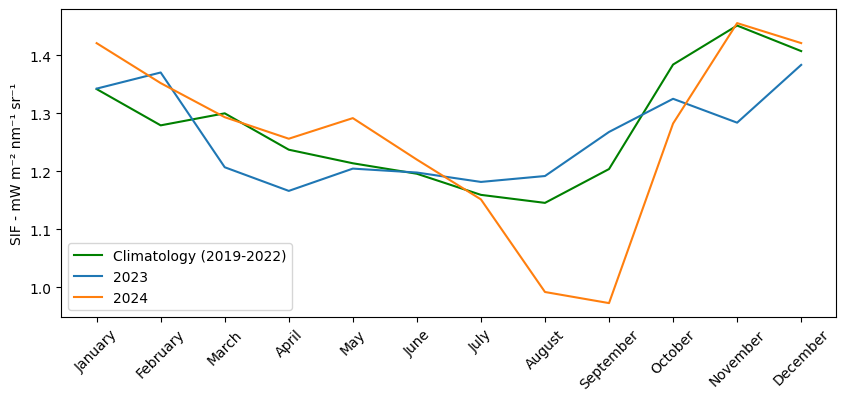

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(months, monthly_means, color='green', label ='Climatology (2019-2022)')
plt.plot(months, sif_monthly[4,:,:,:].mean(axis=(1, 2)), label='2023')
plt.plot(months, sif_monthly[5,:,:,:].mean(axis=(1, 2)), label='2024') 
plt.ylabel("SIF - mW m⁻² nm⁻¹ sr⁻¹")
plt.xticks(rotation=45)
plt.legend()
plt.savefig("pic/sif_climatology.png")
plt.show()

#there seems to be an anomaly in 2024 in august and septemver and then in 2023 it deviates in november and december maybe march april.

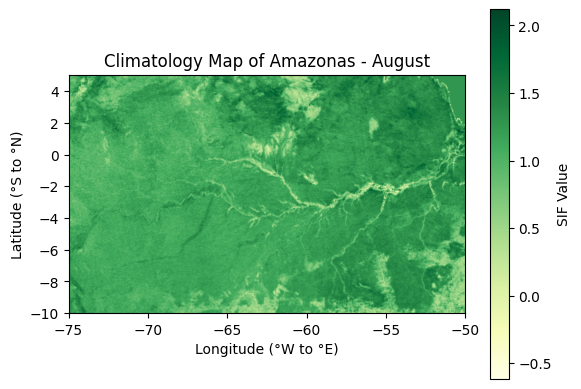

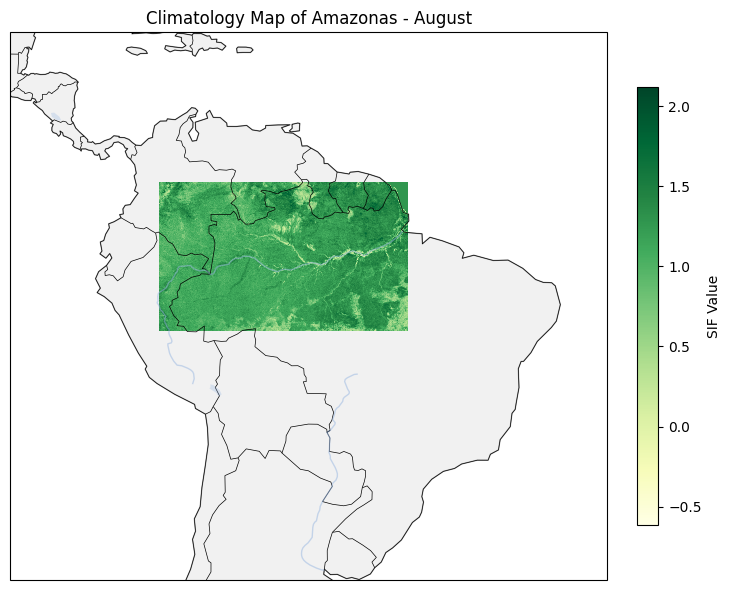

In [59]:
# Choose a month (0-11)
month_idx = 7  # August
plt.imshow(climatology[month_idx], cmap='YlGn', origin = 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='SIF Value')
plt.xlabel("Longitude (°W to °E)")
plt.ylabel("Latitude (°S to °N)")
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()

# Choose a month (0 = January, ..., 11 = December)
month_idx = 7  # August

# Get the SIF data slice (2D array)
sif_data = climatology[month_idx]

# Generate coordinate grids
lat = np.linspace(lat_min, lat_max, sif_data.shape[0])
lon = np.linspace(lon_min, lon_max, sif_data.shape[1])
lon2d, lat2d = np.meshgrid(lon, lat)

# Create a Cartopy map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, -30, -35, 20], crs=ccrs.PlateCarree())  # Wider region for context

# Add features (land, borders, etc.)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.3)

# Plot the SIF data
im = ax.pcolormesh(lon2d, lat2d, sif_data, cmap="YlGn", shading="auto", transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.03, shrink=0.8)
cbar.set_label("SIF Value")

# Add labels
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.tight_layout()
plt.show()

sif_strided shape: (6, 100, 12, 68, 113)
Reshaped sif_strided shape: (6, 100, 12, 68, 100)
sif_patches_combined shape: (600, 12, 68, 100)


/Users/carmenoliver/.pyenv/versions/sif_env/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/carmenoliver/.pyenv/versions/sif_env/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/carmenoliver/.pyenv/versions/sif_env/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/carmenoliver/.pyenv/versions/sif_env/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.z

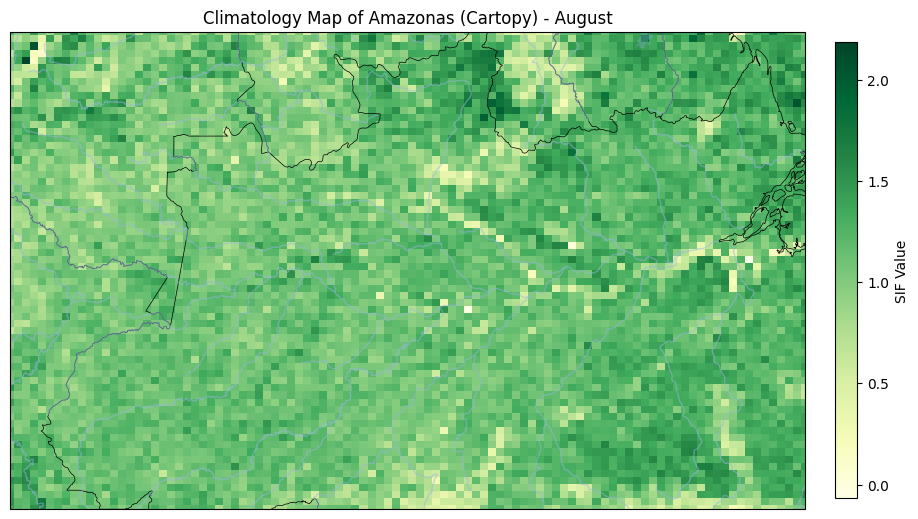

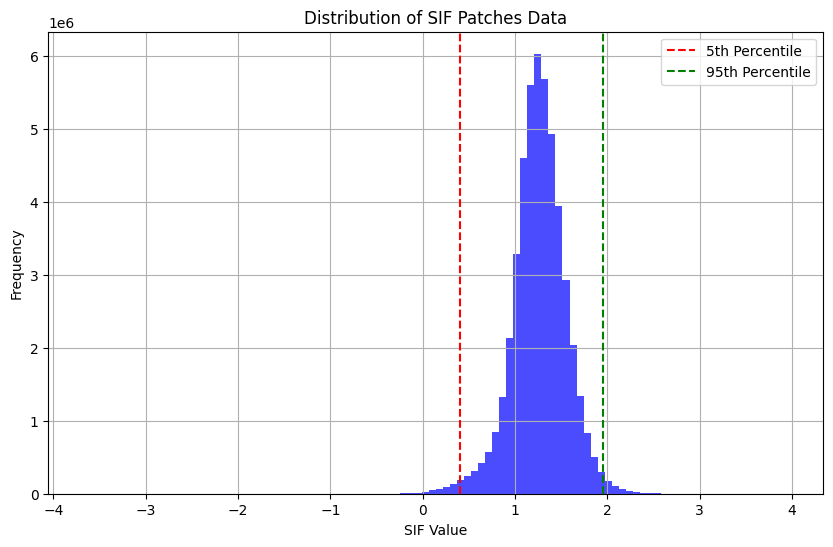

In [87]:

def create_strided_downsamples(data, modulo):
    years, months, h, w = data.shape

    # Crop to make h and w divisible by modulo
    new_h = (h // modulo) * modulo
    new_w = (w // modulo) * modulo
    cropped = data[..., :new_h, :new_w]

    versions = []
    for row_mod in range(modulo):
        for col_mod in range(modulo):
            version = cropped[..., row_mod::modulo, col_mod::modulo]
            versions.append(version)

    return np.stack(versions, axis=1)
sif_strided = create_strided_downsamples(sif_monthly,10) 
print("sif_strided shape:", sif_strided.shape)  # Should be (6, 4, 12, h', w')
sif_strided = sif_strided[:, :, :, :80, :100]
print("Reshaped sif_strided shape:", sif_strided.shape)
# Flatten into fake "years"
sif_patches = sif_strided.reshape(-1, 12, sif_strided.shape[-2], sif_strided.shape[-1])
print("sif_patches_combined shape:", sif_patches.shape)



# Plot the selected SIF patch on a Cartopy map for spatial context
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.3)

im = ax.pcolormesh(
    np.linspace(lon_min, lon_max, sif_patches.shape[-1]),
    np.linspace(lat_min, lat_max, sif_patches.shape[-2]),
    sif_patches[102, month_idx],
    cmap="YlGn",
    shading="auto",
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.03, shrink=0.8)
cbar.set_label("SIF Value")
plt.title(f"Climatology Map of Amazonas (Cartopy) - {months[month_idx]}")
plt.tight_layout()
plt.show()

# Flatten the sif_patches_combined array to a 1D array for distribution plotting
sif_patches_flat = sif_patches.flatten()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(sif_patches_flat, bins=100, color='blue', alpha=0.7)

# Calculate the 5th and 95th percentiles
percentile_5 = np.percentile(sif_patches_flat, 1)
percentile_95 = np.percentile(sif_patches_flat, 99)

# Add vertical lines for the 5th and 95th percentiles
plt.axvline(percentile_5, color='red', linestyle='--', label='5th Percentile')
plt.axvline(percentile_95, color='green', linestyle='--', label='95th Percentile')

# Add legend to the plot
plt.legend()
plt.title("Distribution of SIF Patches Data")
plt.xlabel("SIF Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [88]:
from keras import regularizers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D
from keras.models import Model
import numpy as np

# Clip outliers
sif_monthly_clipped = np.clip(sif_patches, np.percentile(sif_patches, 1), np.percentile(sif_patches, 99))
input_sequences = sif_monthly_clipped[..., np.newaxis]  # Add channel dimension

# Input shape: (12, lat, lon, 1)
input_seq = Input(shape=(12, sif_monthly_clipped.shape[2], sif_monthly_clipped.shape[3], 1))

# --- Encoder ---
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(input_seq)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same',
                       activity_regularizer=regularizers.l1(1e-5))(x)

# --- Decoder (mirror of encoder) ---
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='relu', padding='same')(x)

# --- Autoencoder Model ---
autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 12, 68, 100, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_45 (Conv3D)              │ (None, 12, 68, 100,    │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 6, 34, 50, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_46 (Conv3D)              │ (None, 6, 34, 50, 8)   │         3,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 3, 17, 25, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_47 (Conv3D)              │ (None, 3, 17, 25, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_17 (UpSampling3D) │ (None, 6, 34, 50, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_48 (Conv3D)              │ (None, 6, 34, 50, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_18 (UpSampling3D) │ (None, 12, 68, 100,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_49 (Conv3D)              │ (None, 12, 68, 100, 1) │           433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,553 (37.32 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
autoencoder.fit(input_sequences, input_sequences, 
                epochs=50, 
                batch_size=10, 
                shuffle=True)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 619ms/step - loss: 0.6787
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 618ms/step - loss: 0.1166
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 629ms/step - loss: 0.0776
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 629ms/step - loss: 0.0675
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 640ms/step - loss: 0.0622
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 636ms/step - loss: 0.0597
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 640ms/step - loss: 0.0576
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 641ms/step - loss: 0.0556
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 644ms/step - loss: 0.0532
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 759ms/step - loss: 0.0521
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 733ms/step - loss: 0.0509
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 695ms/step - loss: 0.0498
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 711ms/step - loss: 0.0491
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 724ms/step - loss: 0.0484
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 

In [ ]:
# extract encoder output
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("max_pooling3d_19").output)
encoded_imgs = encoder.predict(sif_patches[..., np.newaxis])
print("Encoded images shape:", encoded_imgs.shape)  # Should be (num_sequences, new_h, new_w, 8)
print("Encoded images:", encoded_imgs[idx, ])

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
Encoded images shape: (600, 3, 17, 25, 8)


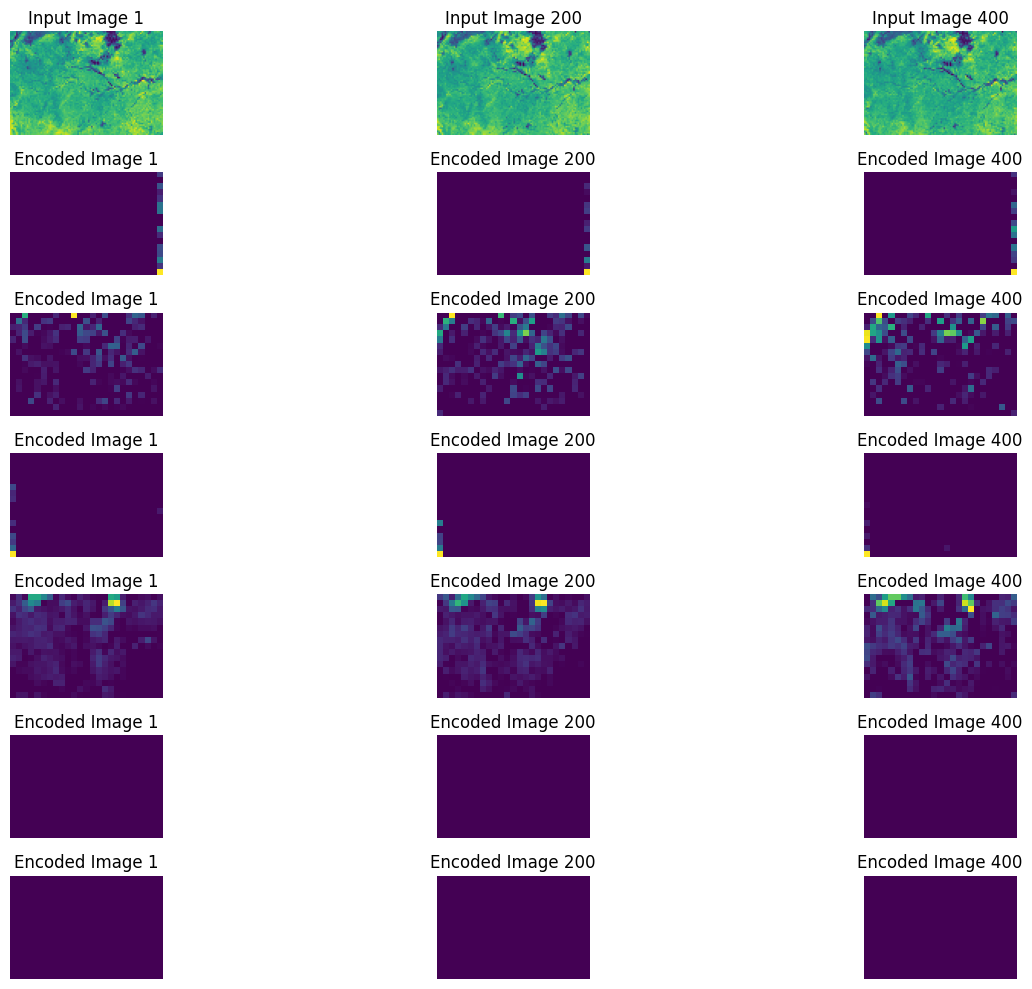

In [152]:
# Visualize some encoded images
num_images_to_plot = 3

indices_to_plot = [0, 199, 399]

# Visualize the input images corresponding to the encoded images
fig, axes = plt.subplots(7, num_images_to_plot, figsize=(15, 10))

for i, idx in enumerate(indices_to_plot):
    # Plot the input image
    input_image = sif_monthly_clipped[idx, :, :, :] 
    axes[0, i].imshow(input_image.mean(axis=0), cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[0, i].set_title(f"Input Image {idx+1}")
    axes[0, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 1]  # Select the first channel of the encoded image
    axes[1, i].imshow(encoded_image[0], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[1, i].set_title(f"Encoded Image {idx+1}")
    axes[1, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 2]  # Select the first channel of the encoded image
    axes[2, i].imshow(encoded_image[0], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[2, i].set_title(f"Encoded Image {idx+1}")
    axes[2, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 3]  # Select the first channel of the encoded image
    axes[3, i].imshow(encoded_image[0], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[3, i].set_title(f"Encoded Image {idx+1}")
    axes[3, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 4]  # Select the first channel of the encoded image
    axes[4, i].imshow(encoded_image[0], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[4, i].set_title(f"Encoded Image {idx+1}")
    axes[4, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 0]  # Select the first channel of the encoded image
    axes[5, i].imshow(encoded_image[1], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[5, i].set_title(f"Encoded Image {idx+1}")
    axes[5, i].axis('off')

    # Plot the encoded image
    encoded_image = encoded_imgs[idx, :, :, :, 0]  # Select the first channel of the encoded image
    axes[6, i].imshow(encoded_image[2], cmap='viridis', origin='lower')  # Mean projection along one axis
    axes[6, i].set_title(f"Encoded Image {idx+1}")
    axes[6, i].axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
(6, 12, 68, 100, 1)


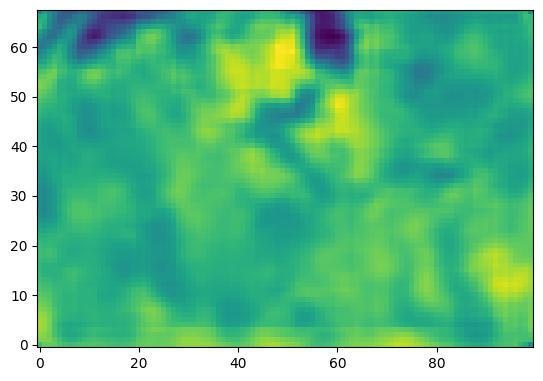

In [184]:

# Resize each year's data to (12, 100, 100)
sif_monthly_resized = np.empty((sif_monthly.shape[0], sif_monthly.shape[1], 68, 100))
for year_idx in range(sif_monthly.shape[0]):
    for month_idx in range(sif_monthly.shape[1]):
        sif_monthly_resized[year_idx, month_idx] = resize(
            sif_monthly[year_idx, month_idx],
            (68, 100),
            anti_aliasing=True
        )


input_data = sif_monthly_resized[..., np.newaxis]  # shape: (6, 12, 100,100 , 1)

# Step 2: Predict reconstructions (you must loop or batch because batch size = 1)
reconstructed = np.zeros_like(input_data)
for i in range(len(sif_monthly_resized)):  # For each year
    inp = input_data[i:i+1]  # shape: (1, 12, 911, 910, 1)
    reconstructed[i:i+1] = autoencoder.predict(inp)

# Step 3: Compute reconstruction error per pixel
print(reconstructed.shape)
reconstruction_error_pixel = np.mean((input_data - reconstructed) ** 2, axis=-1)  


plt.imshow(reconstructed[1, 3, :, :, 0], label='Reconstructed', origin='lower')
plt.show()


In [172]:
# Evaluate the model on the test set:
score = autoencoder.evaluate(sif_monthly_resized, sif_monthly_resized)
print('Test reconstruction loss (MSE):', score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0211
Test reconstruction loss (MSE): 0.02108111046254635


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


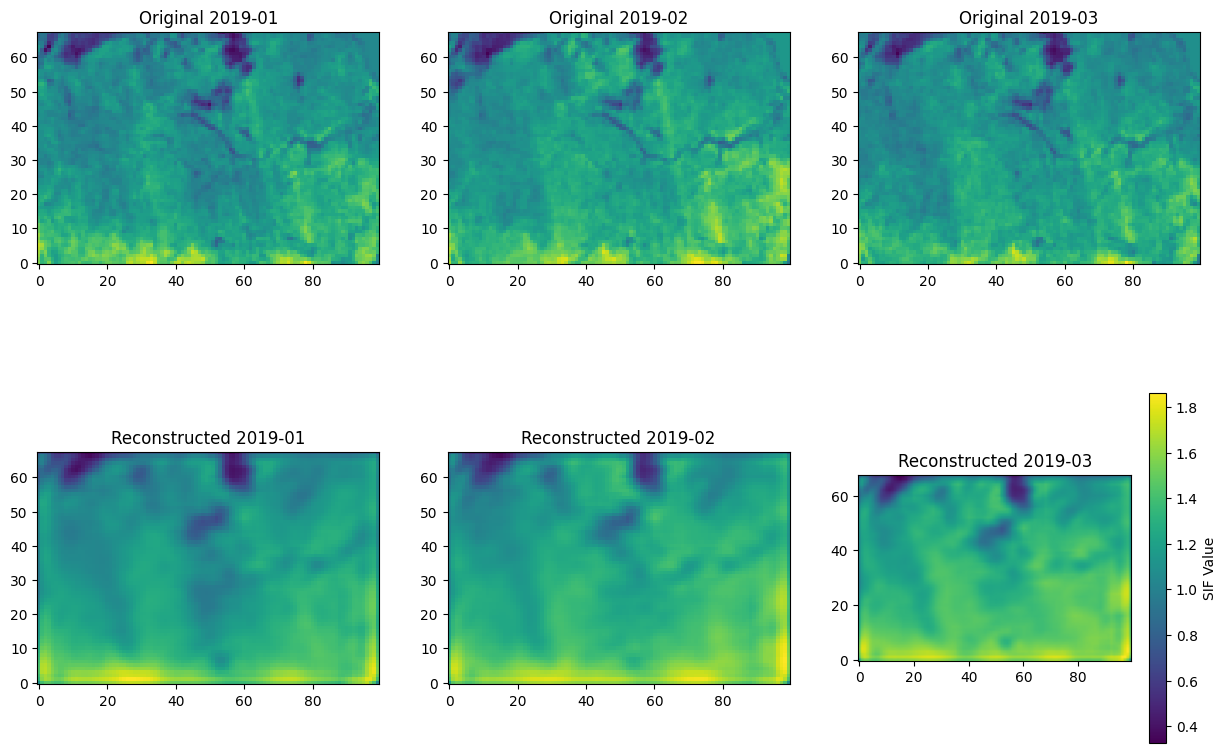

In [173]:
reconstructed_imgs = autoencoder.predict(sif_monthly_resized[..., np.newaxis])
# Adjust the dimensions for visualization
plt.figure(figsize=(15, 10))  # Increase the figure size
n = 3  # Number of images to display
for i in range(3):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sif_monthly_resized[i+2, 0], cmap='viridis', origin='lower')
    ax.set_title(f"Original {time_list[i]}")

    # Reconstructed image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(reconstructed_imgs[i+2, 0], cmap='viridis', origin='lower')
    ax.set_title(f"Reconstructed {time_list[i]}")
    
plt.colorbar(label='SIF Value')
plt.show()

Min overall reconstruction error per month: [[2.81701483e-12 5.62544777e-10 2.89116673e-10 1.70402912e-09
  8.43225863e-09 1.35910840e-10 7.29750660e-12 2.17905291e-12
  1.18932159e-11 2.66138105e-10 2.28536633e-09 3.92489750e-10]
 [1.62577330e-09 5.95840133e-12 4.87862174e-11 7.72604705e-10
  2.45729945e-09 1.02296277e-09 2.96253272e-12 5.02046605e-10
  2.16045170e-10 4.61958923e-12 6.06821276e-10 2.66575753e-10]
 [8.27739285e-11 3.16464681e-09 4.62053502e-10 4.83761099e-10
  1.08444504e-09 8.64032860e-10 1.61097328e-10 9.46012340e-10
  5.61963318e-12 6.10145682e-09 2.17782646e-12 1.23442678e-10]
 [5.48658330e-11 1.40877039e-09 2.06701398e-10 2.29025556e-10
  3.07142779e-10 2.15678433e-09 1.25985653e-10 3.60385358e-10
  5.38936929e-10 4.97507383e-10 2.17669368e-11 4.03985309e-12]
 [1.77696881e-09 7.12129498e-10 1.50636195e-08 8.94007654e-10
  5.89162863e-11 1.44765458e-11 2.58207271e-11 2.51893225e-09
  5.81270605e-09 3.80461850e-10 2.78521281e-10 1.63360101e-09]
 [1.63003206e-09 1.52

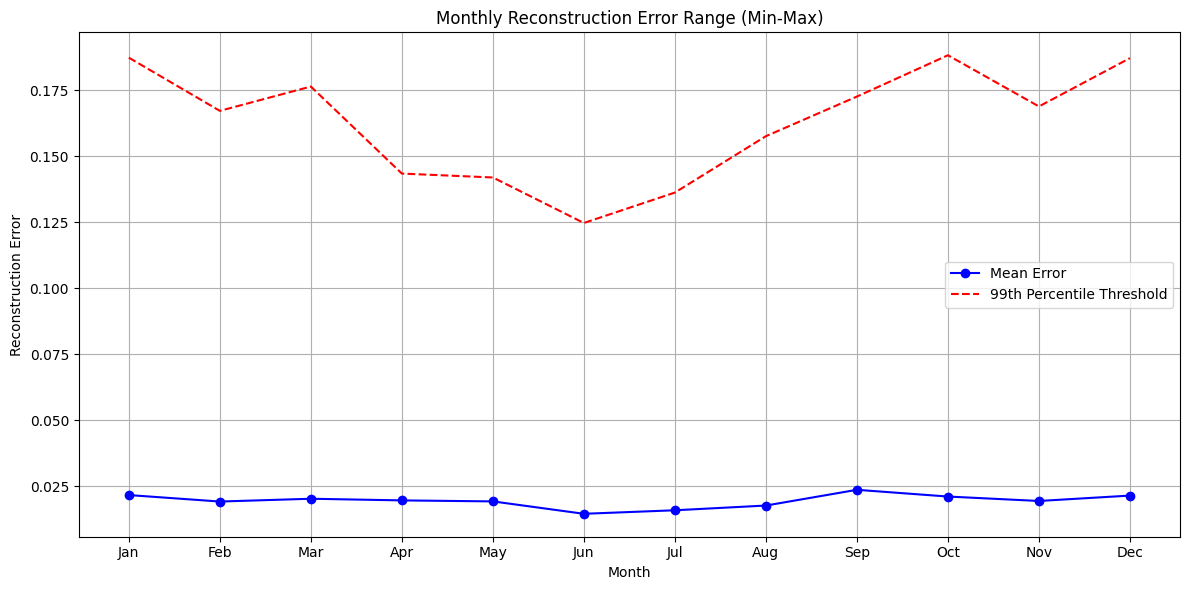

(6, 12, 68, 100)


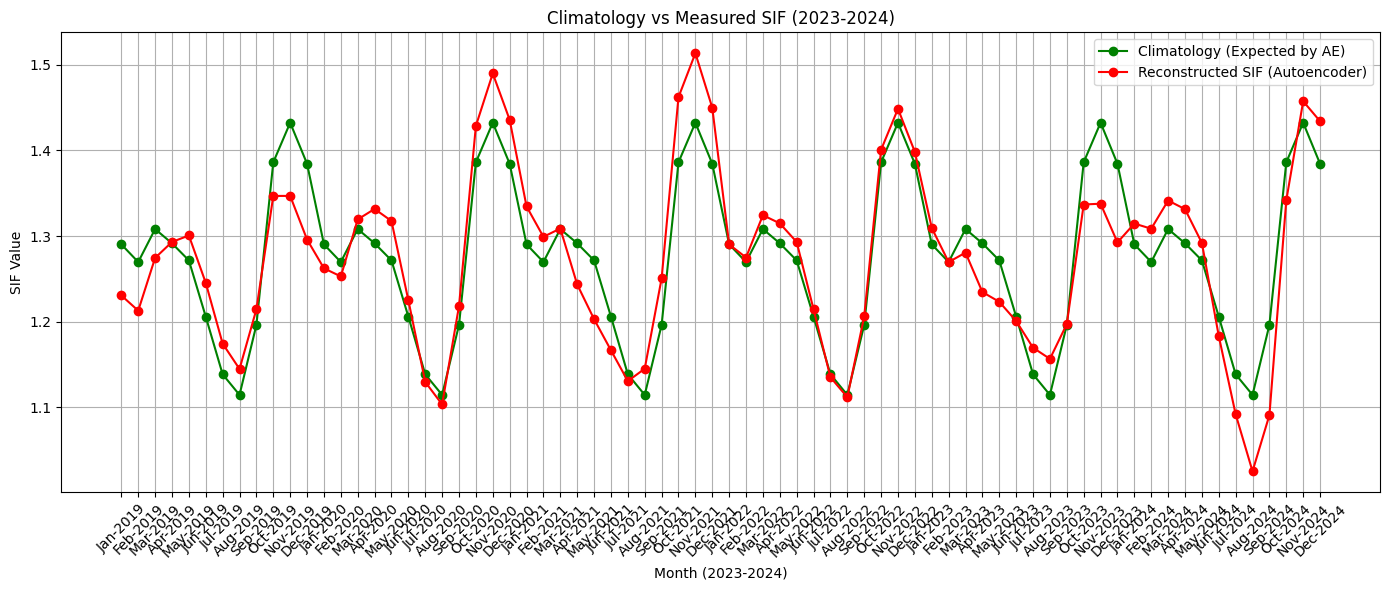

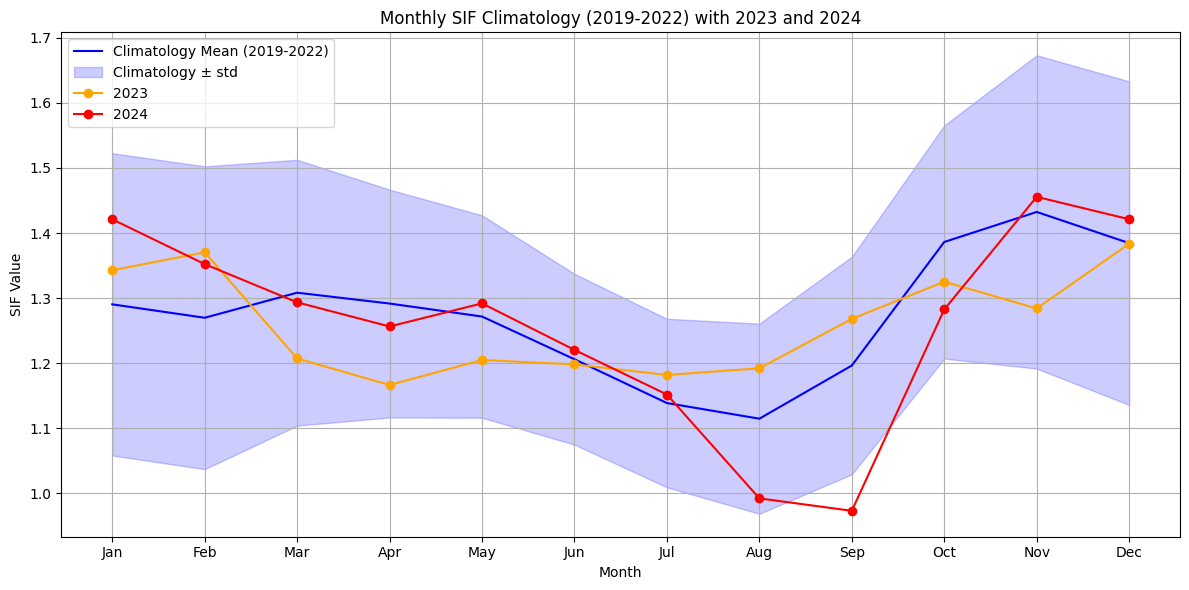

Least reconstruction error index: (np.int64(4), np.int64(5))
Least reconstruction error value: 0.011499312942097533


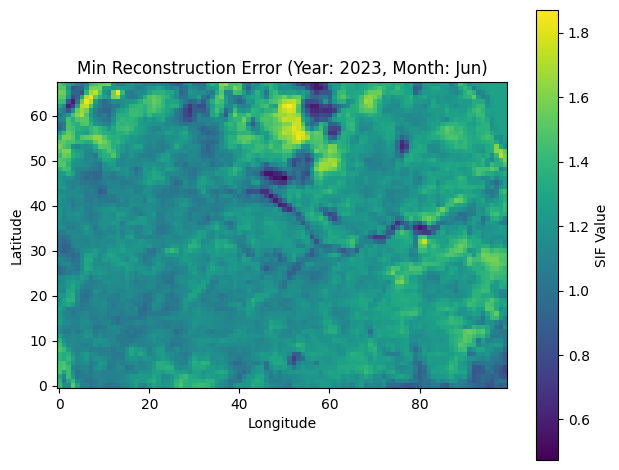

In [189]:
#this threshold is for general areas, not pixel per pixel 
thresholds_per_month = np.percentile(reconstruction_error_pixel, 99, axis=(0, 2, 3))  # shape: (12,)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


# Compute min, max, and mean errors per year and month but over all pixels
min_errors = np.min(reconstruction_error_pixel, axis=(2, 3))  # shape: (6, 12)
max_errors = np.max(reconstruction_error_pixel, axis=(2, 3))  # shape: (6, 12)
mean_errors = np.mean(reconstruction_error_pixel, axis=(2, 3))  # shape: (6, 12)
print("Min overall reconstruction error per month:", min_errors, "Max overall reconstruction error per month:", max_errors)


# Plot
plt.figure(figsize=(12, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(range(12), mean_errors.mean(axis=0), 'b-', label='Mean Error', marker='o')
plt.plot(range(12), thresholds_per_month, 'r--', label='99th Percentile Threshold')

plt.xticks(range(12), months)
plt.xlabel('Month')
plt.ylabel('Reconstruction Error')
plt.title('Monthly Reconstruction Error Range (Min-Max)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


anomalies_month = reconstruction_error_pixel > thresholds_per_month.reshape(1, 12, 1, 1)  #anomalies per month not subject to pixel
print(anomalies_month.shape)
# Compute the usual climatology of SIF per month

# Extend the months list to include 24 months for 2023-2024
extended_months = [f"{month}-{year}" for year in [2019, 2020, 2021, 2022, 2023, 2024] for month in months]

# Concatenate the climatology and measured SIF for 2023-2024
climatology_24_months = np.mean(climatology, axis = (1,2)) # Shape: (24,)
climatology_24_months = np.tile(climatology_24_months, 6)  # Repeat the 12-month climatology 6 times
climatology_AE_mean = np.mean(reconstructed, axis = (0,2,3,4))
climatology_AE_std = np.std(reconstructed, axis = (0,2,3,4))
climatology_AE = np.tile(climatology_AE_mean, 6)
AE_reconstruction = np.mean(reconstructed, axis = (2,3,4)).flatten() 
sif_measured_24_months = np.mean(sif_monthly, axis = (2,3)).flatten()  # Shape: (24,)


plt.figure(figsize=(14, 6))
plt.plot(extended_months, climatology_AE, label="Climatology (Expected by AE)", color="green", marker="o")
#plt.plot(extended_months, climatology_24_months, label="Climatology (Mean of all data)", color="blue", marker="o")
plt.plot(extended_months, AE_reconstruction, label="Reconstructed SIF (Autoencoder)", color="red", marker="o")
#plt.plot(extended_months, sif_measured_24_months, label="Measured SIF (Satellite)", color="green", marker="o")

plt.xlabel("Month (2023-2024)")
plt.ylabel("SIF Value")
plt.title("Climatology vs Measured SIF (2023-2024)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(months, climatology_AE_mean, label='Climatology Mean (2019-2022)', color='blue')
plt.fill_between(months, climatology_AE_mean - climatology_AE_std, climatology_AE_mean + climatology_AE_std, color='blue', alpha=0.2, label='Climatology ± std')

plt.plot(months, np.nanmean(sif_monthly[4], axis=(1, 2)), label='2023', color='orange', marker='o')
plt.plot(months, np.nanmean(sif_monthly[5], axis=(1, 2)), label='2024', color='red', marker='o')

plt.xlabel('Month')
plt.ylabel('SIF Value')
plt.title('Monthly SIF Climatology (2019-2022) with 2023 and 2024')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the input with the least reconstruction error
reconstruction_error = np.mean((input_data - reconstructed) ** 2, axis=(2,3,4)) 
least_error_idx = np.unravel_index(np.argmin(reconstruction_error), reconstruction_error.shape)
least_error_input = input_data[least_error_idx[0], least_error_idx[1]]

print(f"Least reconstruction error index: {least_error_idx}")
print(f"Least reconstruction error value: {reconstruction_error[least_error_idx]}")

# Visualize the input with the least reconstruction error
plt.imshow(least_error_input.squeeze(), cmap='viridis', origin='lower')
plt.colorbar(label='SIF Value')
plt.title(f"Min Reconstruction Error (Year: {years[least_error_idx[0]]}, Month: {months[least_error_idx[1]]})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()




Reconstruction error shape: (6, 12, 68, 100)


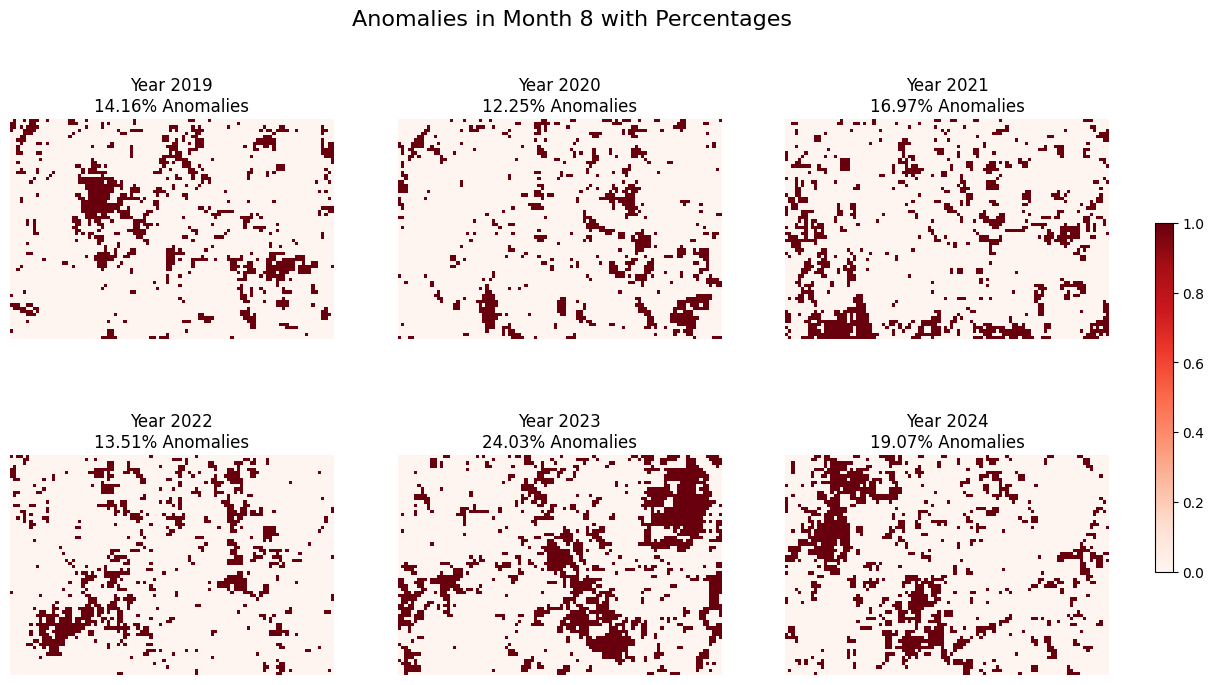

Highlighted Anomaly Percentages Table:
           2019        2020        2021        2022        2023        2024
Jan      11.75%      13.13%      12.85%      12.43%      11.16%  38.68% !!!
Feb      14.24%      10.90%      10.25%      15.04%  31.38% !!!  18.19% !!!
Mar      14.46%      13.54%      11.35%  21.50% !!!      16.69%  22.46% !!!
Apr  20.65% !!!      11.76%      11.35%      17.35%      13.94%  24.94% !!!
May  29.46% !!!      17.47%      12.04%      15.00%       8.29%      17.74%
Jun  21.54% !!!      14.78%      16.94%      17.34%       9.40%  20.00% !!!
Jul      14.00%      11.66%  24.29% !!!       9.59%      16.35%  24.10% !!!
Aug      14.16%      12.25%      16.97%      13.51%  24.03% !!!  19.07% !!!
Sep       9.06%      10.31%       9.94%      12.46%  20.50% !!!  37.74% !!!
Oct      10.22%      15.99%  22.66% !!!      11.72%  19.06% !!!  20.35% !!!
Nov      10.91%  18.34% !!!      15.28%      10.49%  28.71% !!!      16.28%
Dec      11.65%      13.34%      15.37%       8.4

/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_27254/2647311784.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  anomaly_percentages_df_highlighted = anomaly_percentages_df.applymap(


In [188]:
print("Reconstruction error shape:", reconstruction_error_pixel.shape)  # shape: (6, 12, 100, 100)
thresholds_per_month = np.percentile(reconstruction_error_pixel, 99, axis= (0)) 
#print("Thresholds per month:", thresholds_per_month)  # shape: (12, 100, 100) 
anomalies_pixel = reconstruction_error_pixel > thresholds_per_month


anomaly_list = []

for year in range(anomalies_pixel.shape[0]):
    for month in range(12):
        lat_idx, lon_idx = np.where(anomalies_pixel[year, month])
        for i in range(len(lat_idx)):
            anomaly_list.append({
                'year': 2019 + year,  # adjust this based on your start year
                'month': month + 1,
                'lat_idx': lat_idx[i],
                'lon_idx': lon_idx[i],
                'error': reconstruction_error_pixel[year, month, lat_idx[i], lon_idx[i]]
            })

anomaly_df = pd.DataFrame(anomaly_list)


month_idx = 7

# Calculate the percentage of anomalies per year for the selected month
anomaly_percentages = []
for year_idx in range(anomalies_pixel.shape[0]):
    total_pixels = anomalies_pixel[year_idx, month_idx].size
    anomaly_pixels = np.sum(anomalies_pixel[year_idx, month_idx])
    anomaly_percentage = (anomaly_pixels / total_pixels) * 100
    anomaly_percentages.append(anomaly_percentage)

# Add the percentage of anomalies to the map titles
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 6 years → 2 rows × 3 columns
fig.suptitle(f"Anomalies in Month {month_idx + 1} with Percentages", fontsize=16)

for year_idx in range(6):
    ax = axs[year_idx // 3, year_idx % 3]
    anomaly_map = anomalies_pixel[year_idx, month_idx]  # shape: (100, 100)
    
    im = ax.imshow(anomaly_map, cmap='Reds', origin='lower')
    ax.set_title(f"Year {2019 + year_idx}\n{anomaly_percentages[year_idx]:.2f}% Anomalies")
    ax.axis('off')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.015, pad=0.04)
plt.show()


# Calculate the percentage of anomalies for each month over the 6 years
anomaly_percentages_table = []

for month_idx in range(12):
    monthly_percentages = []
    for year_idx in range(anomalies_pixel.shape[0]):
        total_pixels = anomalies_pixel[year_idx, month_idx].size
        anomaly_pixels = np.sum(anomalies_pixel[year_idx, month_idx])
        anomaly_percentage = (anomaly_pixels / total_pixels) * 100
        monthly_percentages.append(anomaly_percentage)
    anomaly_percentages_table.append(monthly_percentages)

# Create a DataFrame for better visualization
anomaly_percentages_df = pd.DataFrame(
    anomaly_percentages_table,
    columns=years,
    index=months
)


# Highlight percentages above 18 with exclamation marks
anomaly_percentages_df_highlighted = anomaly_percentages_df.applymap(
    lambda x: f"{x:.2f}%" + (" !!!" if x > 18 else "")
)

# Display the highlighted table
print("Highlighted Anomaly Percentages Table:")
print(anomaly_percentages_df_highlighted)

# Optionally, save the highlighted table to a CSV file
anomaly_percentages_df_highlighted.to_csv("amazonas_anomaly_percentages_highlighted.csv")

# Convert the anomaly_percentages_df_highlighted to LaTeX format
latex_code = anomaly_percentages_df_highlighted.to_latex(
    index=True, 
    caption="Monthly Anomaly Percentages Highlighted", 
    label="tab:anomaly_percentages", 
    escape=False
)

# Save the LaTeX code to a file
with open("anomaly_percentages_table.tex", "w") as f:
    f.write(latex_code)

# Print the LaTeX code
print(latex_code)

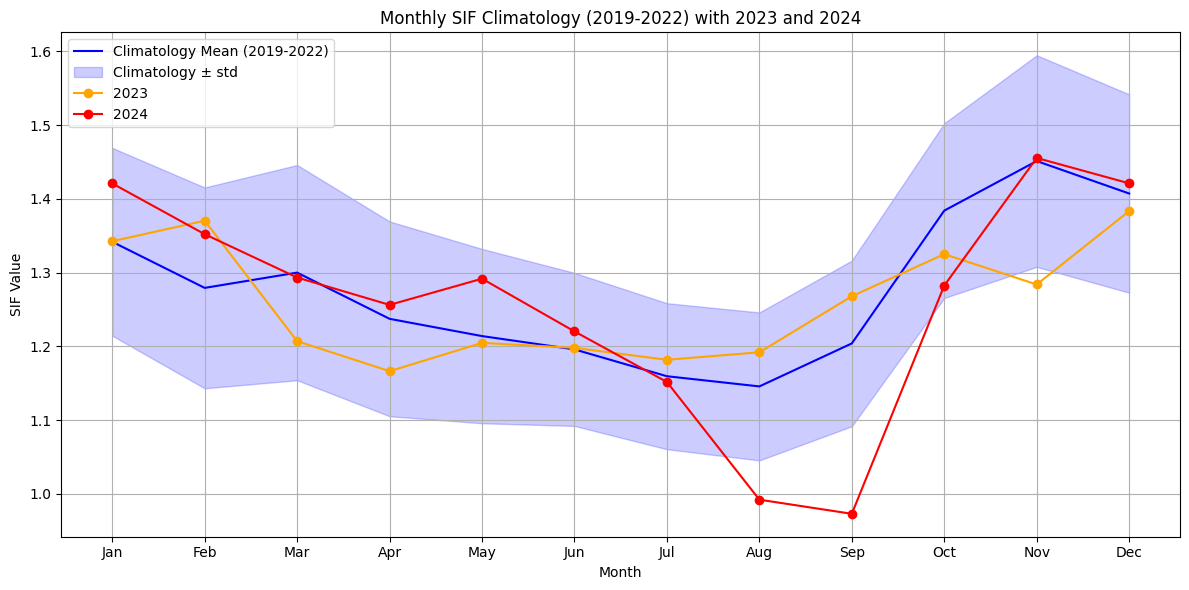

/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_27254/3057696123.py:27: RuntimeWarning: divide by zero encountered in divide
  z_scores = (sif_monthly[4:] - climatology_mean) / climatology_std  # shape: (2, 12, lat, lon)
/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_27254/3057696123.py:27: RuntimeWarning: invalid value encountered in divide
  z_scores = (sif_monthly[4:] - climatology_mean) / climatology_std  # shape: (2, 12, lat, lon)
/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_27254/3057696123.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


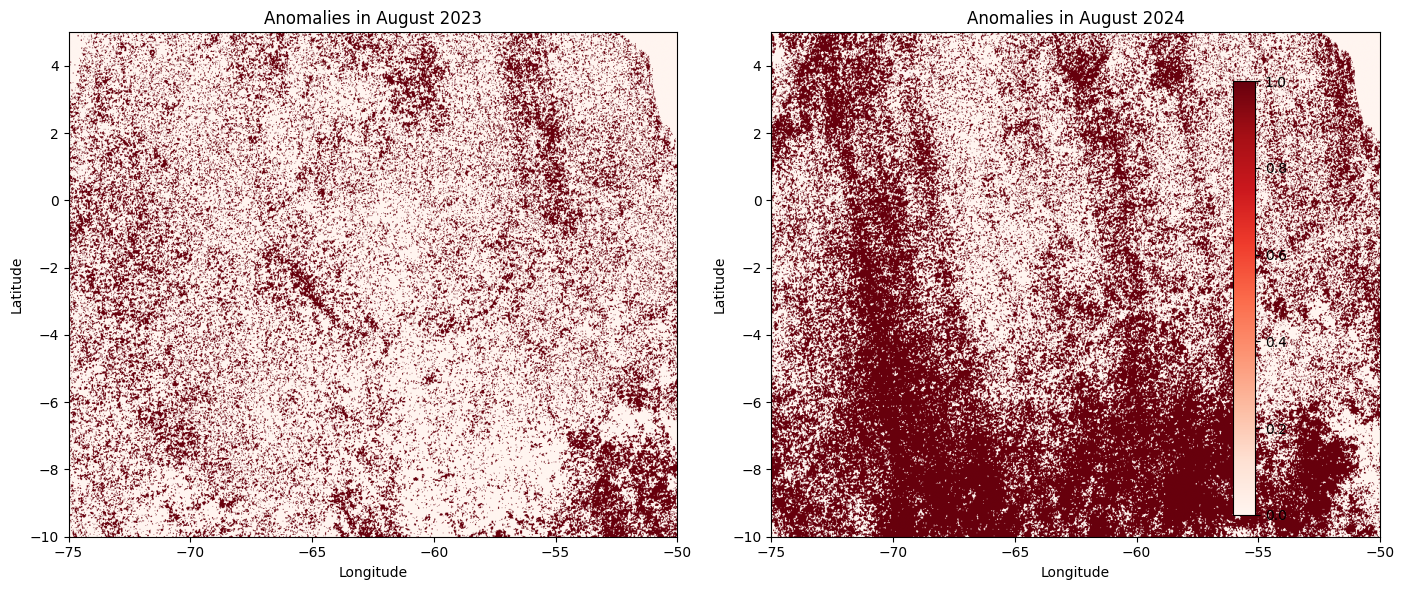

In [201]:
# 1. Compute mean and std for each pixel and month from the first 4 years (2019-2022)
climatology_mean = np.mean(sif_monthly[:4], axis=0)  # shape: (12, lat, lon)
climatology_std = np.std(sif_monthly[:4], axis=0)    # shape: (12, lat, lon)

# Plot climatology mean and std as shaded area, with 2023 and 2024 overlaid
clim_mean = np.nanmean(climatology_mean, axis=(1, 2))  # shape: (12,)
clim_std = np.nanmean(climatology_std, axis=(1, 2))    # shape: (12,)

months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 6))
plt.plot(months_labels, clim_mean, label='Climatology Mean (2019-2022)', color='blue')
plt.fill_between(months_labels, clim_mean - clim_std, clim_mean + clim_std, color='blue', alpha=0.2, label='Climatology ± std')

plt.plot(months_labels, np.nanmean(sif_monthly[4], axis=(1, 2)), label='2023', color='orange', marker='o')
plt.plot(months_labels, np.nanmean(sif_monthly[5], axis=(1, 2)), label='2024', color='red', marker='o')

plt.xlabel('Month')
plt.ylabel('SIF Value')
plt.title('Monthly SIF Climatology (2019-2022) with 2023 and 2024')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Compute z-score for each pixel and month for 2023 and 2024 (years[4:] = [2023, 2024])
z_scores = (sif_monthly[4:] - climatology_mean) / climatology_std  # shape: (2, 12, lat, lon)

# 3. Flag anomalies where |z| > 2
anomaly_z = np.abs(z_scores) > 2  # shape: (2, 12, lat, lon)

# Plot anomaly maps for August (month_idx = 7) for 2023 and 2024
month_idx = 8  # August (0-based index)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
years_to_plot = [2023, 2024]

for i, year_offset in enumerate(range(2)):
    ax = axs[i]
    anomaly_map = anomaly_z[year_offset, month_idx]  # shape: (lat, lon)
    im = ax.imshow(anomaly_map, cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max])
    ax.set_title(f"Anomalies in August {years_to_plot[i]}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.axis('auto')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()

In [200]:
# Calculate anomaly mask for 2023 and 2024 using z_scores (already computed)
# anomaly_mask shape: (2, 12, lat, lon), years[4:] = [2023, 2024]
print("Anomaly mask shape:", anomaly_z.shape)
anomaly_percentages_z = []

for year_offset, year in enumerate(years[4:]):  # 2023, 2024
    year_percentages = []
    for month_idx in range(12):
        mask = anomaly_z[year_offset, month_idx]
        total = np.isfinite(mask).sum()  # Exclude NaNs
        anomalies = np.nansum(mask)
        percent = (anomalies / total) * 100 if total > 0 else np.nan
        year_percentages.append(percent)
    anomaly_percentages_z.append(year_percentages)

# Create DataFrame
months_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
anomaly_z_df = pd.DataFrame(np.array(anomaly_percentages_z).T, columns=[2023, 2024], index=months_short)

print("Percentage of anomalies in 2023 and 2024 (z-score method):")
print(anomaly_z_df.round(3))

# Optionally, save to CSV
anomaly_z_df.to_csv("anomaly_percentages_zscore_2023_2024.csv")

Anomaly mask shape: (2, 12, 683, 1137)
Percentage of anomalies in 2023 and 2024 (z-score method):
       2023    2024
Jan  21.312  36.310
Feb  27.036  29.953
Mar  21.560  30.883
Apr  20.435  26.561
May  19.886  29.227
Jun  21.403  25.592
Jul  22.032  23.400
Aug  25.512  42.471
Sep  26.030  52.403
Oct  26.852  28.447
Nov  33.074  28.714
Dec  32.777  28.707


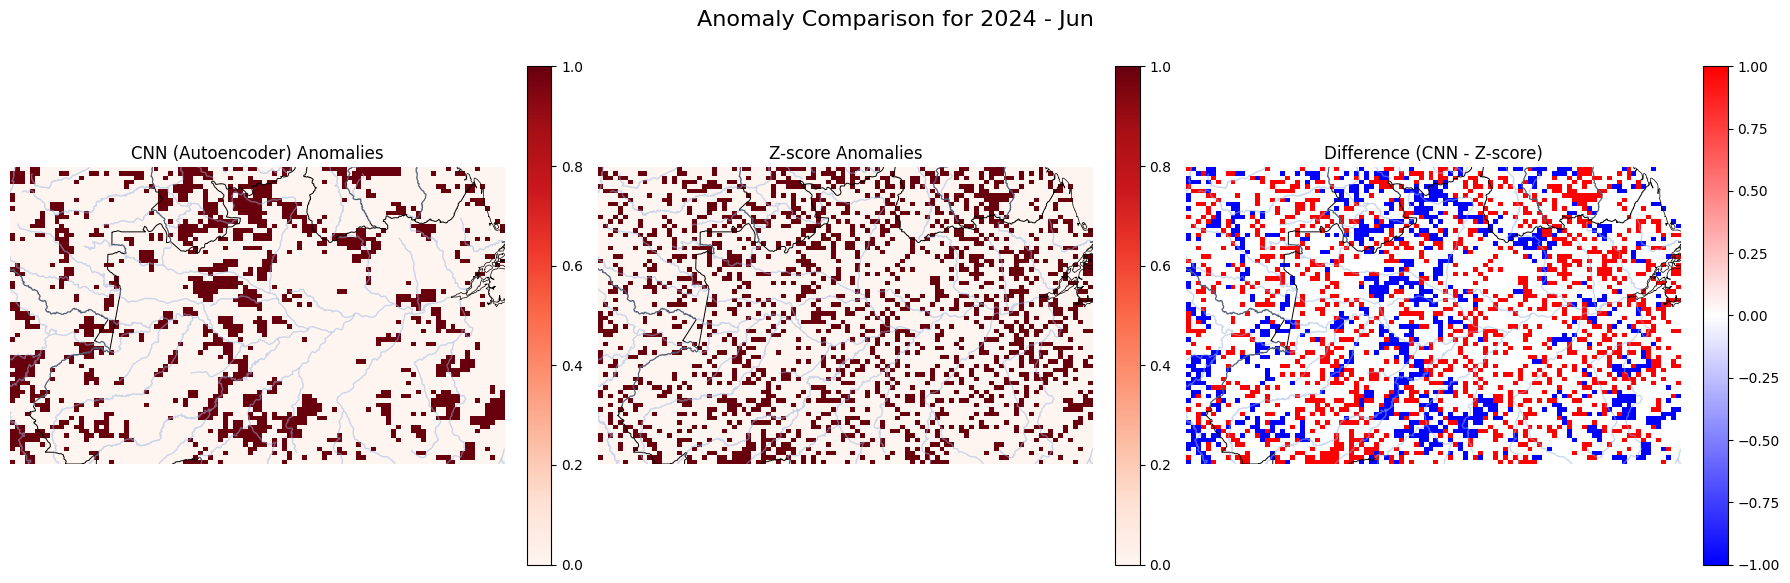

In [256]:

# 1. CNN-based anomalies for 2024 (year_idx=5)
cnn_anomalies_2024 = anomalies_pixel[5]  # shape: (12, 68, 100) or (12, 100, 100) depending on your resizing

# 2. Z-score-based anomalies for 2024 (year_offset=1)
zscore_anomalies_2024 = anomaly_z[1]  # shape: (12, lat, lon)

# For visualization, select a month (e.g., August, index 7)
month_idx = 5

# Resize zscore_anomalies_2024 to (12, 68, 100) using nearest-neighbor interpolation
zscore_anomalies_2024_resized = np.empty((12, 68, 100), dtype=bool)
for m in range(12):
    zscore_anomalies_2024_resized[m] = resize(
        zscore_anomalies_2024[m].astype(float),
        (68, 100),
        order=0,  # nearest-neighbor
        preserve_range=True,
        anti_aliasing=False
    ).astype(bool)

fig = plt.figure(figsize=(18, 6))
fig.suptitle(f"Anomaly Comparison for 2024 - {months[month_idx]}", fontsize=16)

# Define projection and extent for Amazonas
proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]

# CNN-based anomaly map
ax0 = plt.subplot(1, 3, 1, projection=proj)
ax0.set_extent(extent, crs=proj)
ax0.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax0.add_feature(cfeature.BORDERS, linewidth=0.7)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax0.add_feature(cfeature.RIVERS, alpha=0.5)
im0 = ax0.imshow(cnn_anomalies_2024[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj)
ax0.set_title("CNN (Autoencoder) Anomalies")
ax0.axis('off')

# Z-score-based anomaly map
ax1 = plt.subplot(1, 3, 2, projection=proj)
ax1.set_extent(extent, crs=proj)
ax1.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax1.add_feature(cfeature.BORDERS, linewidth=0.7)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.RIVERS, alpha=0.5)
im1 = ax1.imshow(zscore_anomalies_2024_resized[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj)
ax1.set_title("Z-score Anomalies")
ax1.axis('off')

# Difference map
diff_map = zscore_anomalies_2024_resized[month_idx].astype(int) - cnn_anomalies_2024[month_idx].astype(int)
ax2 = plt.subplot(1, 3, 3, projection=proj)
ax2.set_extent(extent, crs=proj)
ax2.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax2.add_feature(cfeature.BORDERS, linewidth=0.7)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.RIVERS, alpha=0.5)
im2 = ax2.imshow(diff_map, cmap='bwr', origin='lower', extent=extent, vmin=-1, vmax=1, transform=proj)
ax2.set_title("Difference (CNN - Z-score)")
ax2.axis('off')

fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

